# Wildfire Detection Threshold Model

author : Camen Piho  
last run : Dec 26, 2019

In [1]:
from collections import namedtuple
import datetime

import matplotlib.pyplot as plt
import numpy as np

from wildfire.goes import downloader, utilities

## Introduction

Xu Zhong, an IBM researcher, set up a threshold model to detect wildfires in Australia using the Himawari-8 satellite. It is discussed [in this paper](https://www.researchgate.net/publication/318455389_Real-time_wildfire_detection_and_tracking_in_Australia_using_geostationary_satellite_Himawari-8) and this notebook provides an implementation of their model using GOES-R satellite data to detect wildfires in the United States.

## Data

In [163]:
GoesScan = namedtuple("GoesScan", ("band_2", "band_3", "band_6", "band_7", "band_14", "band_15"))
CHANNELS = [2, 3, 6, 7, 14, 15]


def get_scan(satellite, region, scan_time_utc):
    s3_paths = s3_object_summaries=downloader.query_s3(
            satellite=satellite, 
            regions=[region], 
            channels=CHANNELS,
            start=scan_time_utc, 
            end=scan_time_utc + datetime.timedelta(minutes=1)
        )
    
    if len(s3_paths) != len(CHANNELS):
        raise ValueError(f"Got {len(s3_paths)} paths, should be {len(CHANNELS)}")
    
    scans_dict = {}
    for s3_path in s3_paths:
        _, channel, _, _ = utilities.parse_filename(s3_path.key)
        s3_url = f"s3://{s3_path.bucket_name}/{s3_path.key}"
        scans_dict[channel] = downloader.read_s3(
            s3_bucket=s3_path.bucket_name, s3_key=s3_path.key
        )
    return GoesScan(
        band_2=_calculate_reflectance_factor(scans_dict[2]),
        band_3=_calculate_reflectance_factor(scans_dict[3]),
        band_6=_calculate_reflectance_factor(scans_dict[6]),
        band_7=_calculate_brightness_temperature(scans_dict[7]),
        band_14=_calculate_brightness_temperature(scans_dict[14]),
        band_15=_calculate_brightness_temperature(scans_dict[15]),
    )


def normalize(sample):
    sample_mean = sample.mean()
    sample_sd = sample.std()
    return (sample - sample_mean) / sample_sd

def _calculate_reflectance_factor(dataset):
    return dataset.assign(reflectance_factor=lambda ds: ds.Rad * ds.kappa0)

def _calculate_brightness_temperature(dataset):
    return dataset.assign(
        brightness_temperature=lambda ds: (
            (ds.planck_fk2 / (np.log((ds.planck_fk1 / ds.Rad) + 1)) - ds.planck_bc1)
            / ds.planck_bc2
        )
    )

In [145]:
goes_scan_1 = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 27, 20, 0))
goes_scan_2 = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 10, 20, 0))
goes_scan_3 = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 11, 1, 18, 0))

scanning_group = (goes_scan_1, goes_scan_2, goes_scan_3)

## is not cloud

In [149]:
def is_cloud(band_2, band_3, band_15):
    band_2 = band_2.reflectance_factor[::4, ::4].data
    band_3 = band_3.reflectance_factor[::2, ::2].data
    band_15 = band_15.brightness_temperature.data
    condition_1 = (band_2 + band_3) >= 1.2
    condition_2 = band_15 <= 265
    condition_3 = ((band_2 + band_3) >= 0.5) & (band_15 <= 285)
    return condition_1 | condition_2 | condition_3

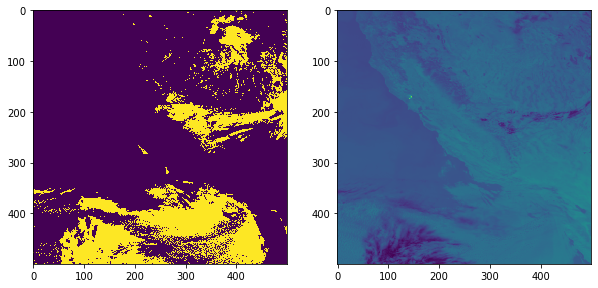

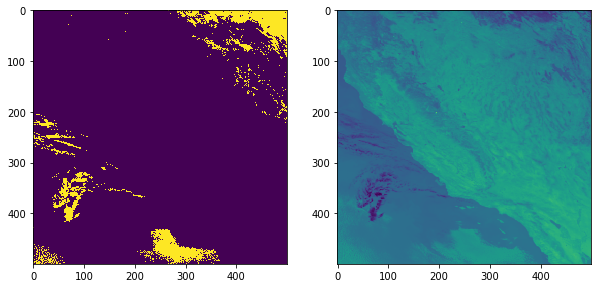

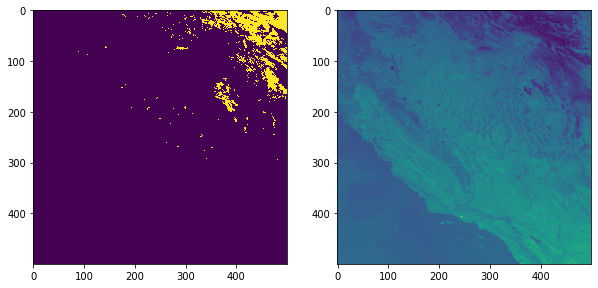

In [150]:
for scan in scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(is_cloud(scan.band_2, scan.band_3, scan.band_15))
    axes[1].imshow(scan.band_7.brightness_temperature)
    plt.show()
    plt.close();

## is not water

In [153]:
def is_water(band_6):
    return band_6.reflectance_factor.data <= 0.03

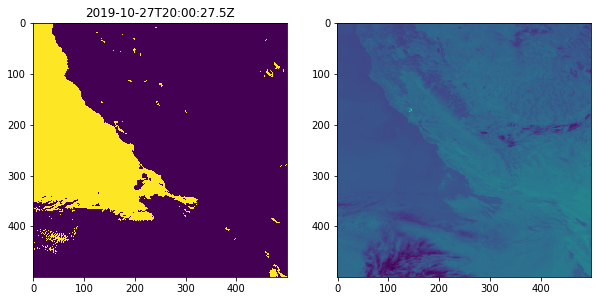

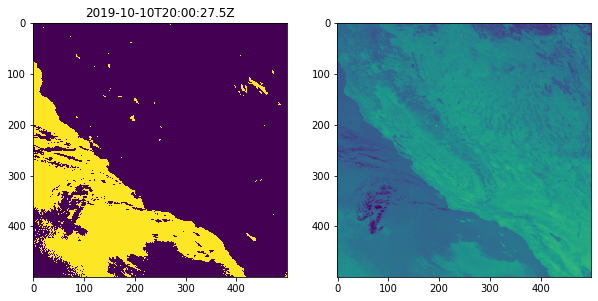

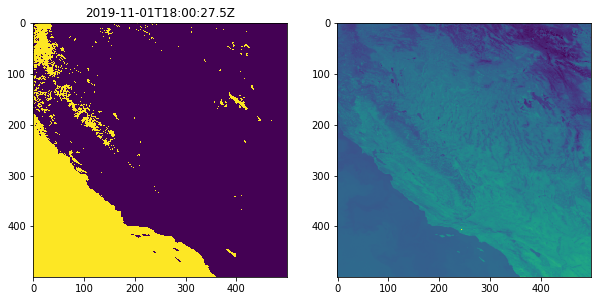

In [155]:
for scan in scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(is_water(scan.band_6))
    axes[1].imshow(scan.band_7.brightness_temperature)
    axes[0].set_title(scan.band_2.time_coverage_start)

## is night

few false positives at night, so if night we can skip filtering out water and cloud pixels

In [31]:
goes_scan_1_night = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 27, 10, 0))
goes_scan_2_night = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 10, 10, 10, 0))
goes_scan_3_night = get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=datetime.datetime(2019, 11, 1, 8, 0))

scanning_group_night = (goes_scan_1_night, goes_scan_2_night, goes_scan_3_night)

In [32]:
def is_night(band_2, band_3):
    return (
        (np.abs(band_2.reflectance_factor.data[::4, ::4]) < 0.008) | 
        (np.abs(band_3.reflectance_factor.data[::2, ::2]) < 0.008)
    )

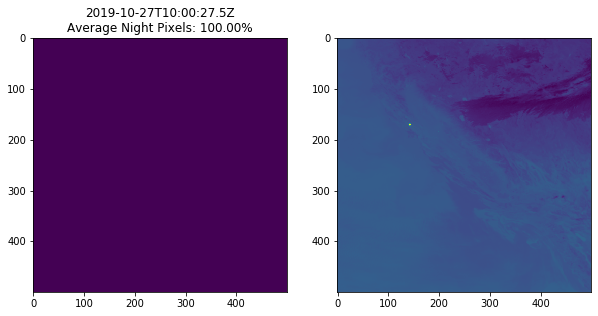

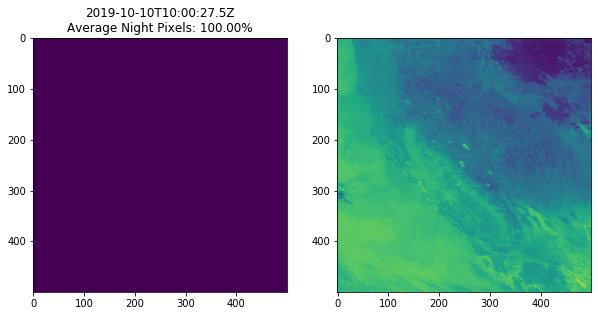

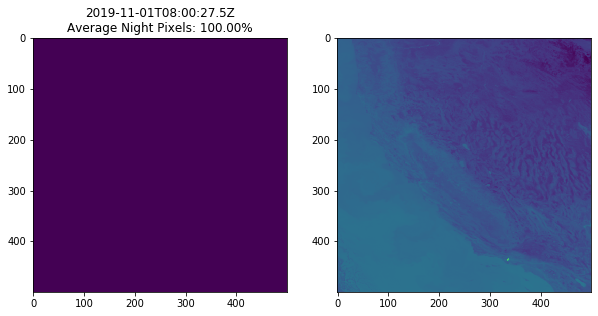

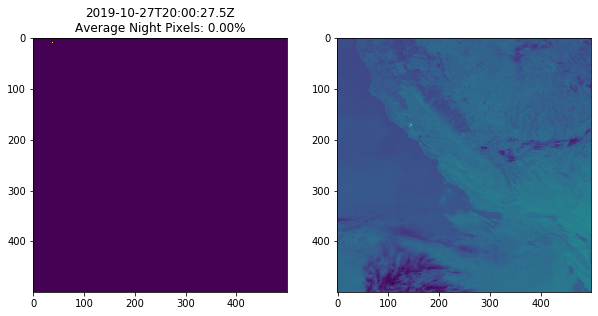

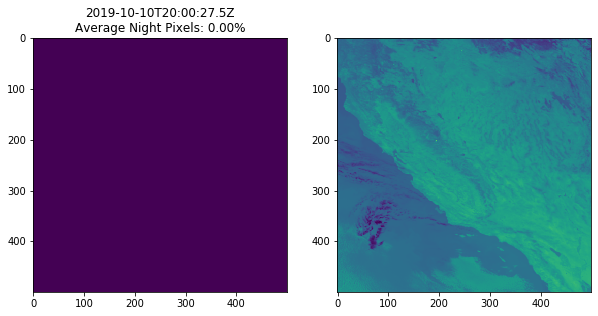

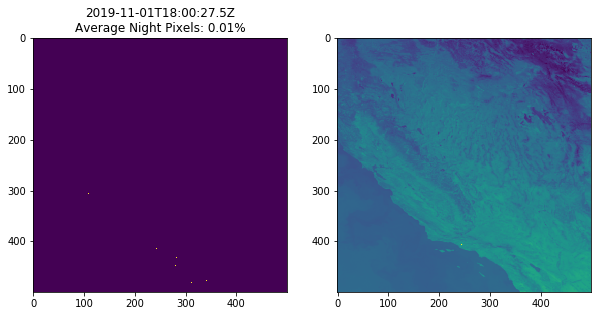

In [159]:
for scan in scanning_group_night + scanning_group:
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    night = is_night(scan.band_2, scan.band_3)
    axes[0].set_title(f"{scan.band_2.time_coverage_start}\nAverage Night Pixels: {night.mean() * 100:.2f}%")
    axes[0].imshow(night)
    axes[1].imshow(scan.band_7.brightness_temperature);

## is hot

In [43]:
def is_hot(band_7, band_14):
    return (
        (normalize(band_7.brightness_temperature.data) > 2) & 
        (normalize(band_7.brightness_temperature.data - band_14.brightness_temperature.data) > 3)
    )

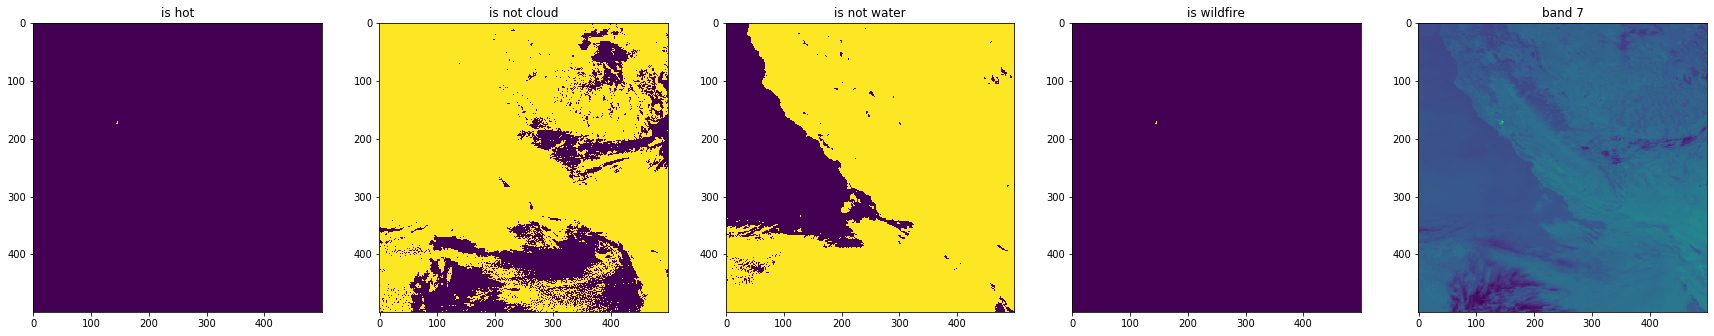

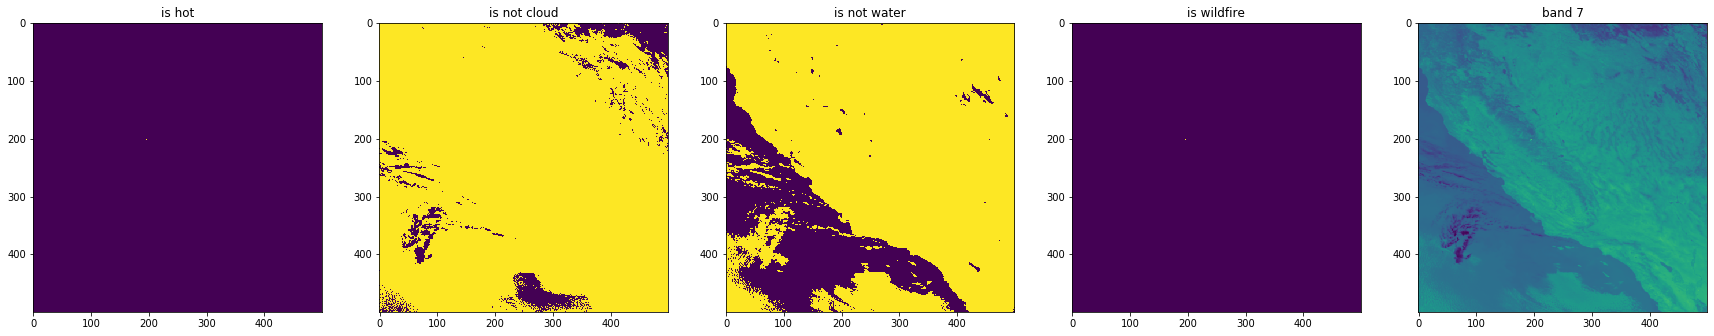

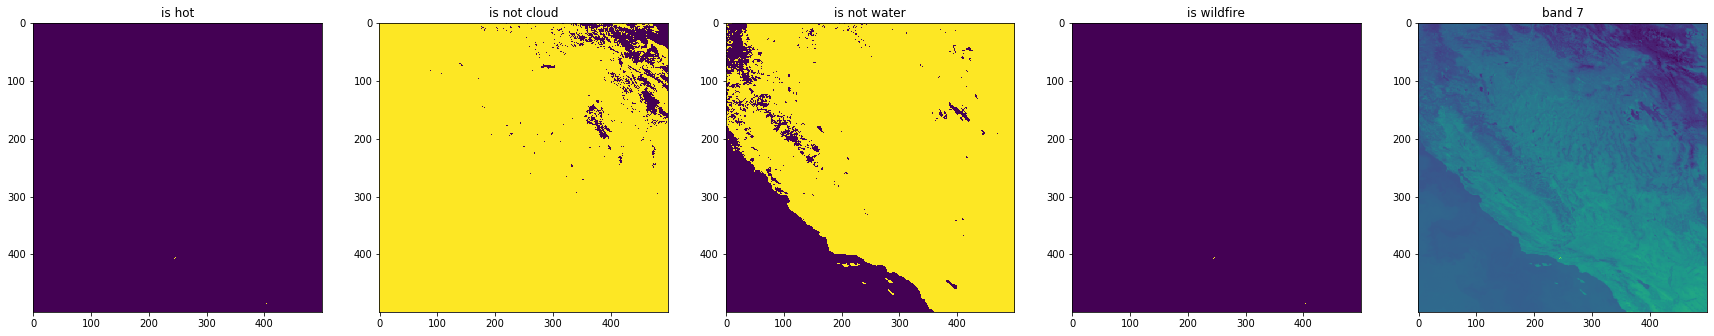

In [160]:
for scan in scanning_group:
    fig, axes = plt.subplots(ncols=5, figsize=(30, 20))
    
    axes[0].imshow(is_hot(scan.band_7, scan.band_14))
    axes[0].set_title("is hot")
    
    axes[1].imshow(
        ~is_cloud(scan.band_2, scan.band_3, scan.band_15)
    )
    axes[1].set_title("is not cloud")
    
    axes[2].imshow(
        ~is_water(scan.band_6)
    )
    axes[2].set_title("is not water")
    
    axes[3].imshow(
        is_hot(scan.band_7, scan.band_14) & 
        (
            is_night(scan.band_2, scan.band_3) |
            (
                ~is_cloud(scan.band_2, scan.band_3, scan.band_15) &
                ~is_water(scan.band_6)
            )
        )
    )
    axes[3].set_title("is wildfire")
    
    axes[4].imshow(scan.band_7.brightness_temperature)
    axes[4].set_title("band 7")

## algorithm

is_hot()? -> false -> end  
is_hot()? -> true -> is_night()? -> true -> end  
is_hot()? -> true -> is_night()? -> false -> is_not_cloud()? and is_not_water? -> end

## when do we first name something a wildfire?

In [59]:
def is_fire(scan):
    return (
        is_hot(scan.band_7, scan.band_14) & 
        (
            is_night(scan.band_2, scan.band_3) |
            (
                is_not_cloud(scan.band_2, scan.band_3, scan.band_15) &
                is_not_water(scan.band_6)
            )
        )
    )

def plot_wildfire(scan):
    fire = is_fire(scan)
    fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
    axes[0].imshow(fire)
    axes[1].imshow(scan.band_7.brightness_temperature)
    plt.title(f"{scan.band_7.time_coverage_start}\n{fire.mean() > 0}")
    plt.show()
    plt.close();

In [60]:
def get_date_range(satellite, region, start, end):
    current = start
    scans = []
    while current <= end:
        print(current)
        try:
            scans.append(get_scan(satellite="noaa-goes17", region="M1", scan_time_utc=current))
            current += datetime.timedelta(hours=24)
        except ValueError:
            current += datetime.timedelta(hours=24)
            continue
        
    return scans

In [61]:
goes_scans_1 = get_date_range("noaa-goes17", "M1", datetime.datetime(2019, 10, 18, 20, 0), datetime.datetime(2019, 11, 10, 20, 0))

2019-10-18 20:00:00
2019-10-19 20:00:00
2019-10-20 20:00:00
2019-10-21 20:00:00
2019-10-22 20:00:00
2019-10-23 20:00:00
2019-10-24 20:00:00
2019-10-25 20:00:00
2019-10-26 20:00:00
2019-10-27 20:00:00
2019-10-28 20:00:00
2019-10-29 20:00:00
2019-10-30 20:00:00
2019-10-31 20:00:00
2019-11-01 20:00:00
2019-11-02 20:00:00
2019-11-03 20:00:00


ValueError: Got 0 paths, should be 6

In [61]:
goes_scans_3 = get_date_range("noaa-goes17", "M1", datetime.datetime(2019, 9, 30, 20, 0), datetime.datetime(2019, 10, 15, 10, 0))

2019-09-30 20:00:00
2019-10-01 20:00:00
2019-10-02 20:00:00
got 0 paths, should be 6
2019-10-03 20:00:00
2019-10-04 20:00:00
2019-10-05 20:00:00
2019-10-06 20:00:00
2019-10-07 20:00:00
2019-10-08 20:00:00
2019-10-09 20:00:00
2019-10-10 20:00:00
2019-10-11 20:00:00
2019-10-12 20:00:00
2019-10-13 20:00:00
2019-10-14 20:00:00


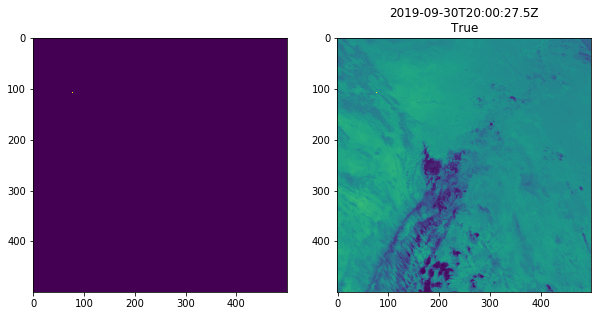

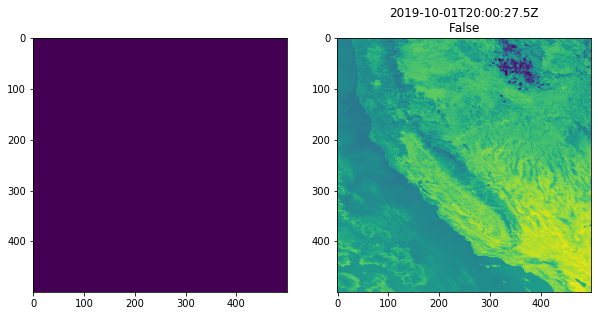

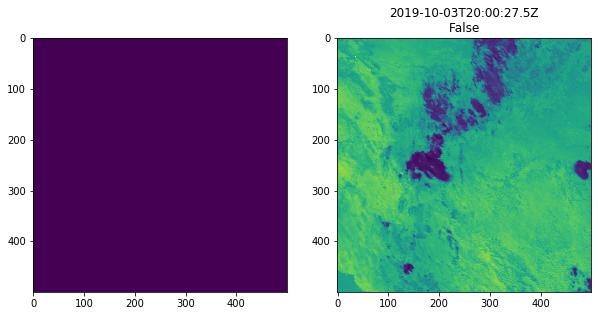

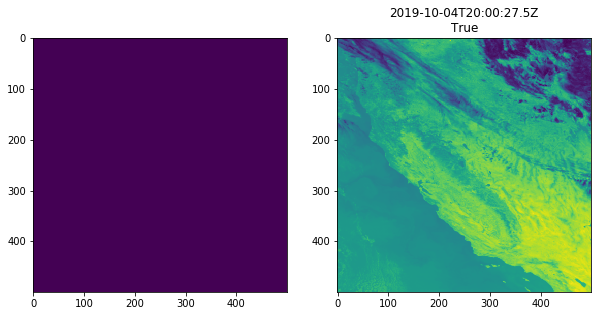

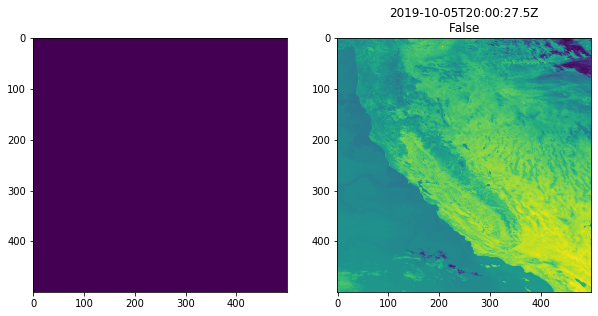

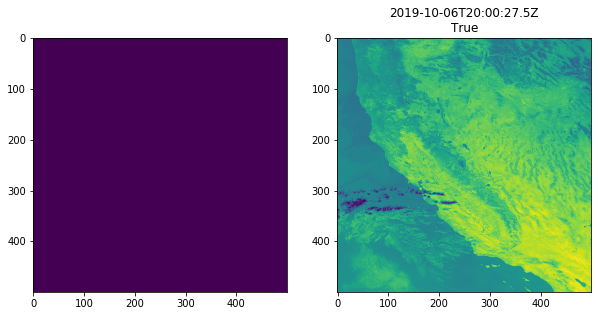

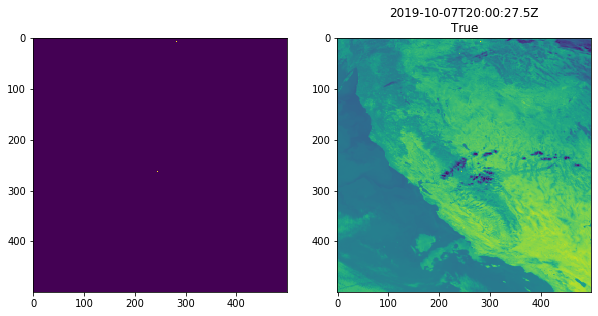

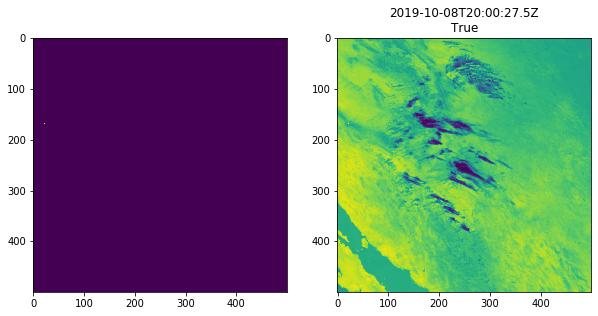

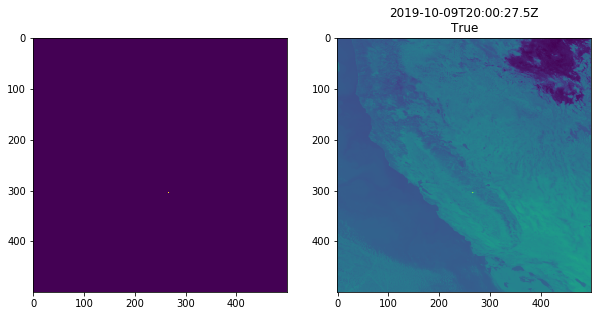

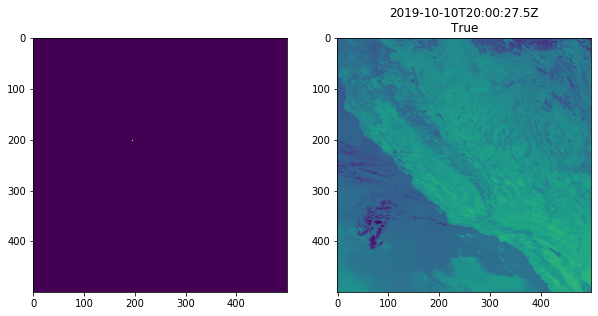

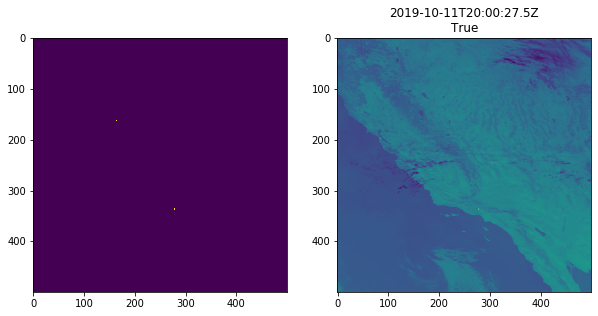

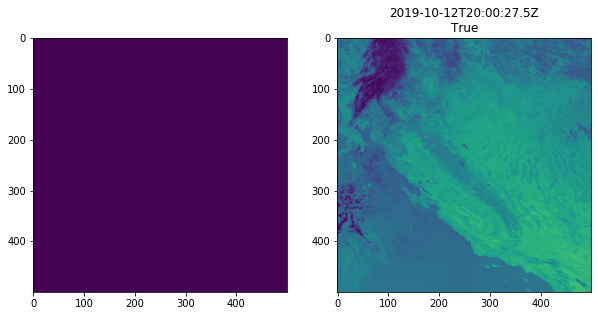

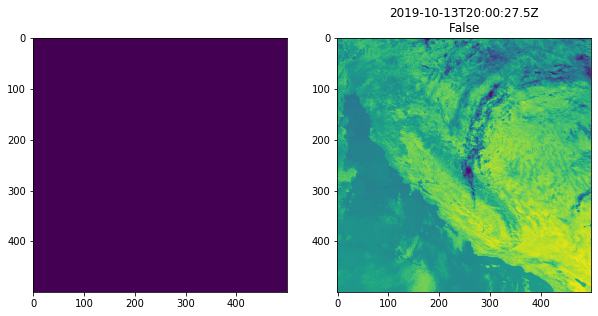

/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/Users/camen/miniconda3/envs/wildfire3.6/lib/python3.6/site-packages/i

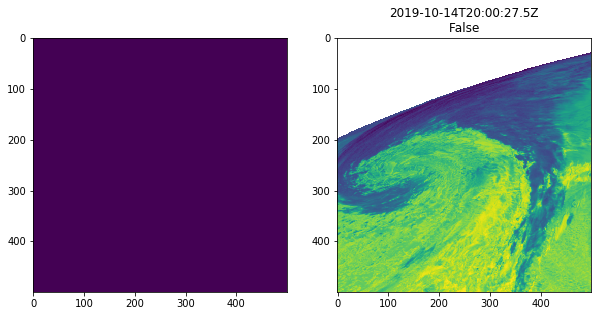

In [79]:
scans = goes_scans_3

for goes_scan in scans:
    try:
        plot_wildfire(goes_scan)
    except:
        continue

In [ ]:
# coal plants
# controlled burns
